## Scope: 
Our Gene Expression Meta-Analysis Templated Solution is designed to provide researchers with an efficient and user-friendly way to perform meta-analyses of gene expression data from various sources. The solution is intended for use by bioinformatics scientists and researchers who are interested in identifying genes that are consistently differentially expressed across multiple studies.

## Guardrails:
- 1 factorial study design with two cohorts (Case Control)
- Minimum 5 datasets as inputs
- Pathway analysis only for mouse and humans
- Current datasets - <b>Bulk RNA Seq </b> 



# *Meta Analysis Template Notebook*

---

# Setting up the current notebook environment


**Info** | **Value**
-------- | ---------
Implemented by | Elucidata
Organism | *Homo Sapiens* \| *Mus musculus*
Date | 29th March, 2022
Docker | RNA-Seq Downstream 2.0: For Transcriptomics analysis
Machine Configuration | Polly 2x-large:16 vCPU, 32GB RAM


---


<h3>
    <span style="color:red">
        IMPORTANT:<br/>
        Use RNA-Seq Downstream 2.0: For Transcriptomics analysis docker<br/>
        It takes ~5 < mins to install all the packages on Polly 2x-large:16 vCPU, 32GB RAM
    </span>
</h3>

---

In [44]:
%%capture
# installing polly-python
!sudo pip3 install polly-python -U --quiet
!sudo pip3 install gseapy --quiet

In [2]:
%%capture
# installing R packages used in this template
!sudo apt-get install libfftw3-dev libfftw3-doc -y
!sudo R -e 'BiocManager::install("DExMA")'
!sudo R -e 'BiocManager::install("EnhancedVolcano")'
!sudo R -e 'BiocManager::install("cowplot")'
!sudo R -e 'BiocManager::install("MetaVolcanoR")'

In [3]:
# importing python libraries
import os
from polly.omixatlas import OmixAtlas
import pandas as pd
import numpy as np
import gseapy as gp
from collections import Counter
from cmapPy.pandasGEXpress.parse_gct import parse
from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.write_gct import write
import matplotlib.pyplot as plt

In [4]:
AUTH_TOKEN = os.environ['POLLY_REFRESH_TOKEN']
omixatlas = OmixAtlas(AUTH_TOKEN)

---

# Downloading Selected datasets for meta analyais

> This notebook template expects the starting point is a `GCT file` which can be downloaded from appropriate omixatlas available. The data type is RNA Seq data with raw counts in the input matrix.


---

## Parameters

`source_repo_name` : omixatlas repo name to download data.

`meta_analysis_datasets` :  The list of datasets to use for meta analysis.

In [5]:
# the source omixatlas to download datasets from
source_repo_key = 'geo_transcriptomics_omixatlas'

# list of dataset ids for meta analysis
meta_analysis_datasets = ['GSE199152_GPL16791_raw',
                          'GSE180415_GPL20301_raw',
                          'GSE119007_GPL20301_raw',
                          'GSE92592_GPL11154_raw',
                          'GSE52463_GPL11154_raw']

download_dir = 'raw_gcts'

In [6]:
# query to veiw the datasets, 6 standard curated fields and the number of sampels in each study
omixatlas.query_metadata(f"""

    SELECT
        dataset_id,
        curated_disease,
        curated_organism,
        curated_tissue,
        curated_cell_type,
        curated_cell_line,
        curated_drug,
        total_num_samples
    FROM {source_repo_key}.datasets
    WHERE dataset_id IN {tuple(meta_analysis_datasets)}

""")

Query execution succeeded (time taken: 2.68 seconds, data scanned: 0.410 MB)
Fetched 5 rows


,dataset_id,curated_cell_line,curated_cell_type,curated_disease,curated_drug,curated_organism,curated_tissue,total_num_samples
0,GSE52463_GPL11154_raw,[None],[None],[Idiopathic Pulmonary Fibrosis],[None],[Homo sapiens],[lung],15
1,GSE119007_GPL20301_raw,[None],[fibroblast],[Idiopathic Pulmonary Fibrosis],[Dinoprostone],[Homo sapiens],[lung],12
2,GSE180415_GPL20301_raw,[None],[fibroblast],[Idiopathic Pulmonary Fibrosis],[None],[Homo sapiens],[lung],8
3,GSE199152_GPL16791_raw,[None],[None],[Idiopathic Pulmonary Fibrosis],[None],[Homo sapiens],[lung],27
4,GSE92592_GPL11154_raw,[None],[None],[Idiopathic Pulmonary Fibrosis],[None],[Homo sapiens],[lung],37


In [7]:
# Downloading gcts 
download_path = os.path.join('data', download_dir)
os.makedirs('results', exist_ok=True)
os.makedirs(download_path, exist_ok=True)
omixatlas.download_dataset(source_repo_key,
                           dataset_ids=meta_analysis_datasets,
                           folder_path=download_path)

downloading data file:GSE180415_GPL20301_raw.gct: 100%|██████████| 12.0M/12.0M [00:00<00:00, 25.8MiB/s]
downloading data file:GSE52463_GPL11154_raw.gct: 100%|██████████| 5.33M/5.33M [00:00<00:00, 15.8MiB/s]]
downloading data file:GSE199152_GPL16791_raw.gct: 100%|██████████| 21.2M/21.2M [00:00<00:00, 30.5MiB/s]
downloading data file:GSE92592_GPL11154_raw.gct: 100%|██████████| 26.1M/26.1M [00:00<00:00, 36.9MiB/s]
downloading data file:GSE119007_GPL20301_raw.gct: 100%|██████████| 13.8M/13.8M [00:00<00:00, 27.7MiB/s]


# Preprocessing the GCT files
    
__Steps:__ 
1. Harmonizing `Case` and `Control` between each dataset
2. Removing samples that don't map to any of the expected labels present
3. Imputing genes between that are present in atleast 70% of the studies
4. Creating and saving new processed GCT files


---

## Parameters

`conditions`: Python dictionary with keys as the labels and values as either `Case` or `Control`.

`condition_col` : The column metadata column where the `conditions` dictionary maps to.

`impute`: If the missing genes are to be imputed or not.

`input_dir` : name of the directory, for the pre processing step, where raw gcts are present.

`ouput_dir` : name of the directory, for saving file after the processing step, where pre processed gcts are placed.

In [8]:
# renaming the expected condtions in the kw_curated_column to have same `Case` and `Control` naming
conditions = {
    'Normal': 'Control',
    'Idiopathic Pulmonary Fibrosis': 'Case',
    '["Idiopathic Pulmonary Fibrosis", "Pulmonary Fibrosis"]': 'Case',
}

# the GCT column metadata column header for the analysis
condition_col = 'kw_curated_disease'

# To Impute data or not
impute = True

# input directory
input_dir = 'raw_gcts'

# output directory
output_dir = 'processed_gcts'

In [9]:
def filter_condition(case_status, condition_dict=conditions):
    
    if case_status in condition_dict:
        return condition_dict[case_status]
    return None

def pre_process_gct(gct, condition_col=condition_col):
    
    # adding kw_condition col info
    new_data_df = gct.data_df.copy()
    new_col_metadata = gct.col_metadata_df.copy()
    new_col_metadata['kw_condition'] = (new_col_metadata[condition_col]
                                            .apply(filter_condition)
                                       )
    
    # getting sample names for the None conditions
    samples_to_drop = new_col_metadata[new_col_metadata['kw_condition'].isna()].index
    
    # dropping samples from col metadata and data matrix
    new_col_metadata = new_col_metadata.drop(samples_to_drop, axis=0)
    new_data_df = new_data_df.drop(samples_to_drop, axis=1)
    
    # creating new gct
    processed_gct = GCToo(data_df=new_data_df,
                          col_metadata_df=new_col_metadata,
                          row_metadata_df=gct.row_metadata_df
                         )
    
    return processed_gct

def impute_data(gct, gene_list):
    
    # finding the missing genes that meet the cutoff and missing from the dataset
    missing_genes = list(set(gene_list).difference(gct.data_df.index))
    
    # if genes are missing imputing the dataset cohort median
    if (missing_genes):
        case_ids = gct.col_metadata_df.query("kw_condition == 'Case'").index
        control_ids = gct.col_metadata_df.query("kw_condition == 'Control'").index
        all_sample_ids = gct.data_df.columns
        imputed_genes_df = pd.DataFrame(columns=missing_genes,
                                        index=all_sample_ids)
        
        # Calcuating the Case cohort's cohort median
        case_median = np.median(gct.data_df[case_ids]
                                   .values
                                   .flatten()
                                  )
        # Calcuating the Control cohort's cohort median
        control_median = np.median(gct.data_df[control_ids]
                               .values
                               .flatten()
                              )
        
        # rounding off with the floor imputed value, futher steps expect integers
        imputed_genes_df.loc[case_ids,] = np.floor(case_median)
        imputed_genes_df.loc[control_ids,] = np.floor(control_median)

        # adding the imputed genes to the gct data df
        imputed_data_df = pd.concat([gct.data_df, imputed_genes_df.T])
        new_row_metadata = pd.DataFrame(index=imputed_data_df.index)
    
        # creating a new gct object with the imputed data
        imputed_gct = GCToo(data_df=imputed_data_df,
                            col_metadata_df=gct.col_metadata_df,
                            row_metadata_df=new_row_metadata)

        return imputed_gct
    return gct
    
raw_data_path = os.path.join('data', download_dir) # input directory
destination_path = os.path.join('data', output_dir) # output directory

os.makedirs(destination_path, exist_ok=True) # creating the output directory

raw_files = os.listdir(raw_data_path) # reading files from the input directory

# Calcuating the 70% cutoff value for the missing genes
max_gene_freq = len(raw_files)
min_gene_treshold = 0.7
cutoff_freq = np.ceil(min_gene_treshold * max_gene_freq)

genes_all = []
unprocessed_gct_data = {}

# reading the input gct files
for file in raw_files:
    gct = parse(
        os.path.join(raw_data_path, file)
    )
    dataset_id = os.path.splitext(file)[0]
    unprocessed_gct_data[dataset_id] = gct
    raw_data = gct.data_df
    current_gene_list = raw_data.index
    genes_all.extend(current_gene_list)

# filtering genes that do not meet the cutoff threshold
gene_freq_info = Counter(genes_all).items()
filtered_gene_freq_info = [(gene, count) for gene, count in gene_freq_info if count >= cutoff_freq]
genes_required = [gene for gene, _ in filtered_gene_freq_info]

# pre processing the gcts
processed_gct_data = {dataset_id: pre_process_gct(gct) for dataset_id, gct in unprocessed_gct_data.items()}

# imputing missing values
# if impute is false imputation will not take place
imputed_gct_data = processed_gct_data

if (impute):
    imputed_gct_data = {dataset_id: impute_data(gct, genes_required) for dataset_id, gct in processed_gct_data.items()}

# writing the imputed gct files to the output directory
for dataset_id, imputed_gct in imputed_gct_data.items():
    processed_filename = os.path.join(destination_path, dataset_id)
    write(imputed_gct, processed_filename)

---
## Importing required libraries for R
---

In [10]:
meta_analysis_packages <- c("dplyr", "mapGCT", "DExMA",
                            "DESeq2", "cowplot", "ggplot2",
                            "stringr", "RColorBrewer", "pheatmap",
                            "MetaVolcanoR")
# suppressing startup messages from libraries
. <- suppressPackageStartupMessages(
        lapply(meta_analysis_packages, require, character.only = T)
)

---

# Cochran's Q test & I-squared test

> A hetrogenity score below 0.25 across all 4 quartiles is the minimum requirement for a fixed effect model.

---

## Parameters

`input_dir`: name of the directory, for the Q-Q plot and I squared results, where the pre-processed gcts are present.

In [11]:
input_dir <- 'processed_gcts'

parsing as GCT v1.3

data/processed_gcts/GSE119007_GPL20301_raw.gct 62548 rows, 12 cols, 8 row descriptors, 57 col descriptors

parsing as GCT v1.3

data/processed_gcts/GSE180415_GPL20301_raw.gct 62548 rows, 8 cols, 8 row descriptors, 54 col descriptors

parsing as GCT v1.3

data/processed_gcts/GSE199152_GPL16791_raw.gct 62548 rows, 27 cols, 8 row descriptors, 49 col descriptors

parsing as GCT v1.3

data/processed_gcts/GSE52463_GPL11154_raw.gct 71983 rows, 15 cols, 0 row descriptors, 55 col descriptors

parsing as GCT v1.3

data/processed_gcts/GSE92592_GPL11154_raw.gct 62548 rows, 37 cols, 8 row descriptors, 49 col descriptors



[1] "I^2 Quantiles"


,DExMA::heterogeneityTest(ma_obj)
,<dbl>
0%,0.0000000
25%,0.0000000
50%,0.0000000
75%,0.1588752


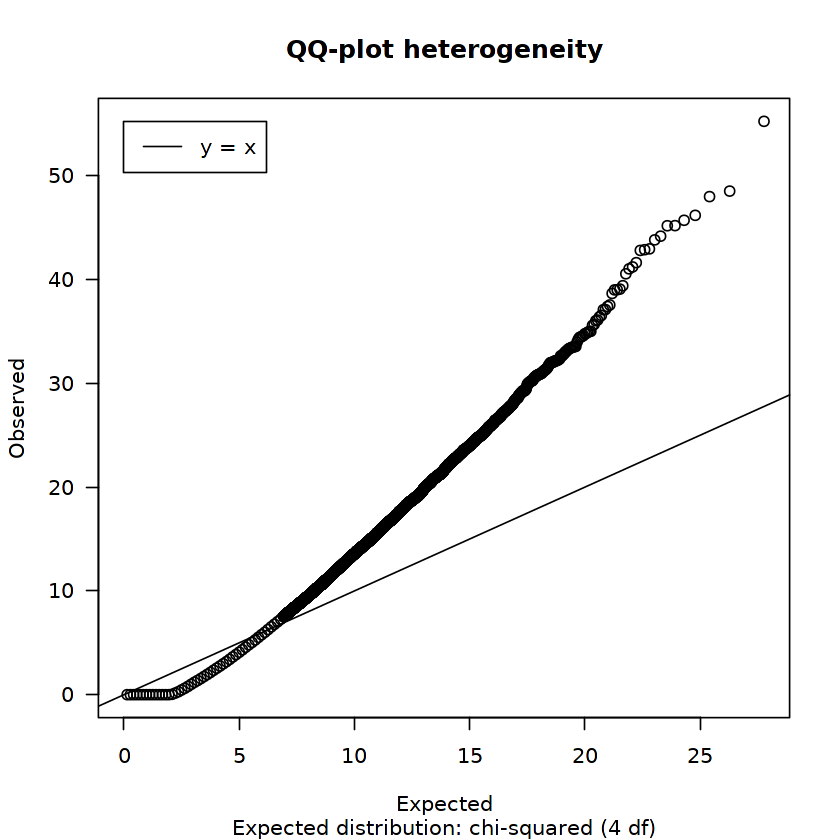

In [12]:
gct_files <- list.files(
    paste0('data/', input_dir), # gct file directory
    full.names = TRUE
)

# initializing 
i <- 1

exp_matrix_list <- list()
pheno_data_list <- list()
pheno_group_list <- list()
pheno_case_list <- list()
pheno_control_list <- list()

for (gct_file in gct_files) {
    # reading GCT file
    
    gct <- mapGCT::parse_gct(gct_file)
    
    exp_matrix_list[[i]] <- gct@mat # data matrix
    pheno_data_list[[i]] <- gct@cdesc # metadata
    pheno_group_list[[i]] <- 'kw_condition' # Additional column with Case and Control condition 
    pheno_case_list[[i]] <- 'Case' # disease condition for the gct
    pheno_control_list[[i]] <- 'Control' # reference condition for the gct
    
    i = i + 1
}
ma_obj = DExMA::createObjectMA(
    listEX = exp_matrix_list,
    listPheno = pheno_data_list,
    namePheno = pheno_group_list,
    expGroups = pheno_case_list,
    refGroups = pheno_control_list
)

i_sq_result <- as.data.frame(DExMA::heterogeneityTest(ma_obj))
i_sq_result

---
## PCA and Heat map plots
---
## Parameters

`input_dir`: name of the directory, for the DESeq2, where the pre-processed gcts are present.

In [13]:
input_dir <- 'processed_gcts'

In [14]:
input_files <- list.files(
                paste0('data/', input_dir),
                full.names = TRUE
)
box_plot_list <- list()
pca_plot_list <- list()
heat_map_plot_list <- list()
for (input_file in input_files) {
    
    # reading gct data
    gct  <- mapGCT::parse_gct(input_file)
    
    # gct data matrix
    exp_data <- gct@mat
    # gct column metadata    
    pdata <- gct@cdesc
    
    # creating DESeq2 object from the gct input file
    dds <- suppressWarnings(
            DESeq2::DESeqDataSetFromMatrix(countData = exp_data,
                                  colData = pdata,
                                  design = ~ kw_condition)
                    )
    
    dataset_id <- stringr::str_extract(string = input_file,
                                       pattern = '(?<=/)[^/]*(?=\\.)')
    
    
    # VST normalization for plotting graphs
    vsd <- DESeq2::vst(dds)
    
    # plotting PC1 and PC2 on the kw_condition
    pca_plot = DESeq2::plotPCA(vsd, intgroup = "kw_condition") +
                    ggtitle(dataset_id)
    
    pca_plot_list[[dataset_id]] <- pca_plot
    
    # plotting heat map
    sampleDists <- dist(t(assay(vsd))) # calcuating euclidian distances between samples
    sampleDistMatrix <- as.matrix(sampleDists)
    rownames(sampleDistMatrix) <- paste(vsd$kw_condition, vsd$id, sep='_')
    colnames(sampleDistMatrix) <- NULL
    colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
    heat_map_plot <- pheatmap(sampleDistMatrix,
                              main=dataset_id,
                              clustering_distance_rows=sampleDists,
                              clustering_distance_cols=sampleDists,
                              col=colors,
                              silent=T)
    
    heat_map_plot_list[[dataset_id]] <- heat_map_plot[[4]]
}

pca_plots <- cowplot::plot_grid(plotlist = pca_plot_list,
                            ncol = 1,
                            nrow = length(input_files),
                            align = 'v'
                            )

heat_maps <- cowplot::plot_grid(plotlist = heat_map_plot_list,
                            ncol = 1,
                            nrow = length(input_files),
                            align = 'v'
                            )

# Saving plots

ggplot2::ggsave(
    'results/pca_plots.pdf',
    plot = pca_plots, height = 32, width = 8, dpi = 300)

ggplot2::ggsave(
    'results/heat_maps.pdf',
    plot = heat_maps, height = 32, width = 8, dpi = 300)

parsing as GCT v1.3

data/processed_gcts/GSE119007_GPL20301_raw.gct 62548 rows, 12 cols, 8 row descriptors, 57 col descriptors

converting counts to integer mode

parsing as GCT v1.3

data/processed_gcts/GSE180415_GPL20301_raw.gct 62548 rows, 8 cols, 8 row descriptors, 54 col descriptors

converting counts to integer mode

parsing as GCT v1.3

data/processed_gcts/GSE199152_GPL16791_raw.gct 62548 rows, 27 cols, 8 row descriptors, 49 col descriptors

converting counts to integer mode

parsing as GCT v1.3

data/processed_gcts/GSE52463_GPL11154_raw.gct 71983 rows, 15 cols, 0 row descriptors, 55 col descriptors

converting counts to integer mode

parsing as GCT v1.3

data/processed_gcts/GSE92592_GPL11154_raw.gct 62548 rows, 37 cols, 8 row descriptors, 49 col descriptors

converting counts to integer mode



---

# Differential Analysis with DESeq2

---
## Parameters

`input_dir`: name of the directory, for the DESeq2, where the pre-processed gcts are present.

`output_dir`: name of the direcotry, for the result table of DESeq2, where the result csvs are placed.

In [15]:
input_dir <- 'processed_gcts'
output_dir <- 'DESeq2_res'

In [16]:
input_files <- list.files(
                paste0('data/', input_dir),
                full.names = TRUE
)

output_path <- paste0('data/', output_dir, '/')
dir.create(output_path)

volcano_plot_list <- list()
for (input_file in input_files) {
    
    # reading gct data
    gct  <- mapGCT::parse_gct(input_file)
    
    # gct data matrix
    exp_data <- gct@mat
    # gct column metadata    
    pdata <- gct@cdesc
    
    # creating DESeq2 object from the gct input file
    dds <- DESeq2::DESeqDataSetFromMatrix(countData = exp_data,
                                  colData = pdata,
                                  design = ~ kw_condition)
    
    # setting reference as Control in design
    dds$kw_condition <- relevel(dds$kw_condition, ref = "Control")
    
    dds <- DESeq2::DESeq(dds)
    res <- DESeq2::results(dds)
    
    dataset_id <- stringr::str_extract(string = input_file,
                                       pattern = '(?<=/)[^/]*(?=\\.)')
    
    res_filename = paste0(output_path, dataset_id, '.csv')
    write.csv(res, res_filename)
    
    volcano_plot <- EnhancedVolcano::EnhancedVolcano(res,
                                         lab = rownames(res),
                                         x = 'log2FoldChange',
                                         y = 'padj',
                                         title = dataset_id
                                                )
    
    volcano_plot_list[[dataset_id]] <- volcano_plot + ggplot2::theme_minimal()
}
    
volcano_plots <- cowplot::plot_grid(plotlist = volcano_plot_list,
                            ncol = 1,
                            nrow = length(input_files),
                            align = 'v'
                        )

# Saving plots
ggplot2::ggsave(
    'results/volcano_plots.pdf',
    plot = volcano_plots, height = 32, width = 8, dpi = 300)

Warning message in dir.create(output_path):
“'data/DESeq2_res' already exists”
parsing as GCT v1.3

data/processed_gcts/GSE119007_GPL20301_raw.gct 62548 rows, 12 cols, 8 row descriptors, 57 col descriptors

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

parsing as GCT v1.3

data/processed_gcts/GSE180415_GPL20301_raw.gct 62548 rows, 8 cols, 8 row descriptors, 54 col descriptors

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model

## Random Effect Model with MetaVolcanoR

---
## Parameters

`input_dir`: name of the directory, for the meta analysis with random effect model, where the DESeq2 results are present.

`output_csv`: name of the csv file, for the result table of random effect model, result csv will be place in the results folder.

`n_cores`: numbers of cpu to be used by the Random Effect Model, depending on the compute machine.

In [17]:
input_dir <- 'DESeq2_res'
output_csv <- 'rem_model_res.csv'
n_cores <- 16 # using 16 cores for Polly 2x-large

In [18]:
plot_forest <- function(gene_name, rem_model) {
    MetaVolcanoR::draw_forest(remres=rem_model,
                              gene = gene_name,
                              genecol = "Symbol", 
                              foldchangecol = "log2FoldChange",
                              llcol = "CI.L", 
                              rlcol = "CI.R",
                              outputfolder = "results",
                              draw = "PDF")
}

diff_exp_list <- list()
diff_exp_files <- list.files(
        paste0('data/', input_dir, '/'),
    full.names = TRUE)

for (diff_exp_file in diff_exp_files) {
    
    dataset_id <- stringr::str_extract(string = diff_exp_file,
                                       pattern = '(?<=/)[^/]*(?=\\.)')
    
    # diff exp list name must be unique character identifiers
    current_de_table <- utils::read.csv2(diff_exp_file, row.names = 1, sep=',')
    
    # calculating left and right confidence intervals
    current_de_table['CI.L'] <- as.double(current_de_table$log2FoldChange) - (1.96 * as.double(current_de_table$lfcSE))
    current_de_table['CI.R'] <- as.double(current_de_table$log2FoldChange) + (1.96 * as.double(current_de_table$lfcSE))
    current_de_table <- current_de_table %>% mutate_if(is.character, as.numeric)
    current_de_table['Symbol'] <- rownames(current_de_table)

    diff_exp_list[[dataset_id]] <- current_de_table
}

meta_degs_rem <- MetaVolcanoR::rem_mv(diffexp = diff_exp_list,
                                      pcriteria = 'padj',
                                      foldchangecol = 'log2FoldChange',
                                      geneidcol = 'Symbol',
                                      collaps = FALSE,
                                      llcol = 'CI.L',
                                      rlcol = 'CI.R',
                                      vcol = NULL,
                                      cvar = TRUE,
                                      metathr = 0.01,
                                      outputfolder = "results",
                                      draw = 'PDF',
                                      ncores = n_cores) # reduce the number of cores depending on the machine


rem_result <- meta_degs_rem@metaresult # random effect model result

# writing out the file
write.csv(rem_result, 
           paste0('results/', output_csv)
        )
# saving rem_model for later use
saveRDS(meta_degs_rem, 'results/rem_model.rds')

metavolcano_plot <- meta_degs_rem@MetaVolcano +
    geom_point() +
    ggtitle('Random Effect model')

  index   Symbol log2FoldChange_1 CI.L_1 CI.R_1 vi_1 log2FoldChange_2   CI.L_2
1 44447  LGALS7B               NA     NA     NA   NA        -2.496414 -9.27982
2 42346    IGHG1               NA     NA     NA   NA               NA       NA
3 42396 IGHV3-19               NA     NA     NA   NA               NA       NA
4 42368  IGHV1-3               NA     NA     NA   NA               NA       NA
5 50446   MS4A6E               NA     NA     NA   NA               NA       NA
6 42417 IGHV3-49               NA     NA     NA   NA               NA       NA
    CI.R_2     vi_2 log2FoldChange_3   CI.L_3   CI.R_3      vi_3
1 4.286991 11.97798         5.074822 3.302878 6.846766 0.8173119
2       NA       NA         3.116646 1.424029 4.809264 0.7457712
3       NA       NA         3.290854 1.895023 4.686686 0.5071704
4       NA       NA         3.565485 2.012159 5.118811 0.6280772
5       NA       NA         3.588243 2.508732 4.667754 0.3033485
6       NA       NA         2.682823 1.403105 3.962542 0.

Warning message:
“Removed 42470 rows containing missing values (geom_errorbarh).”


Warning message:
“Removed 42470 rows containing missing values (geom_errorbarh).”


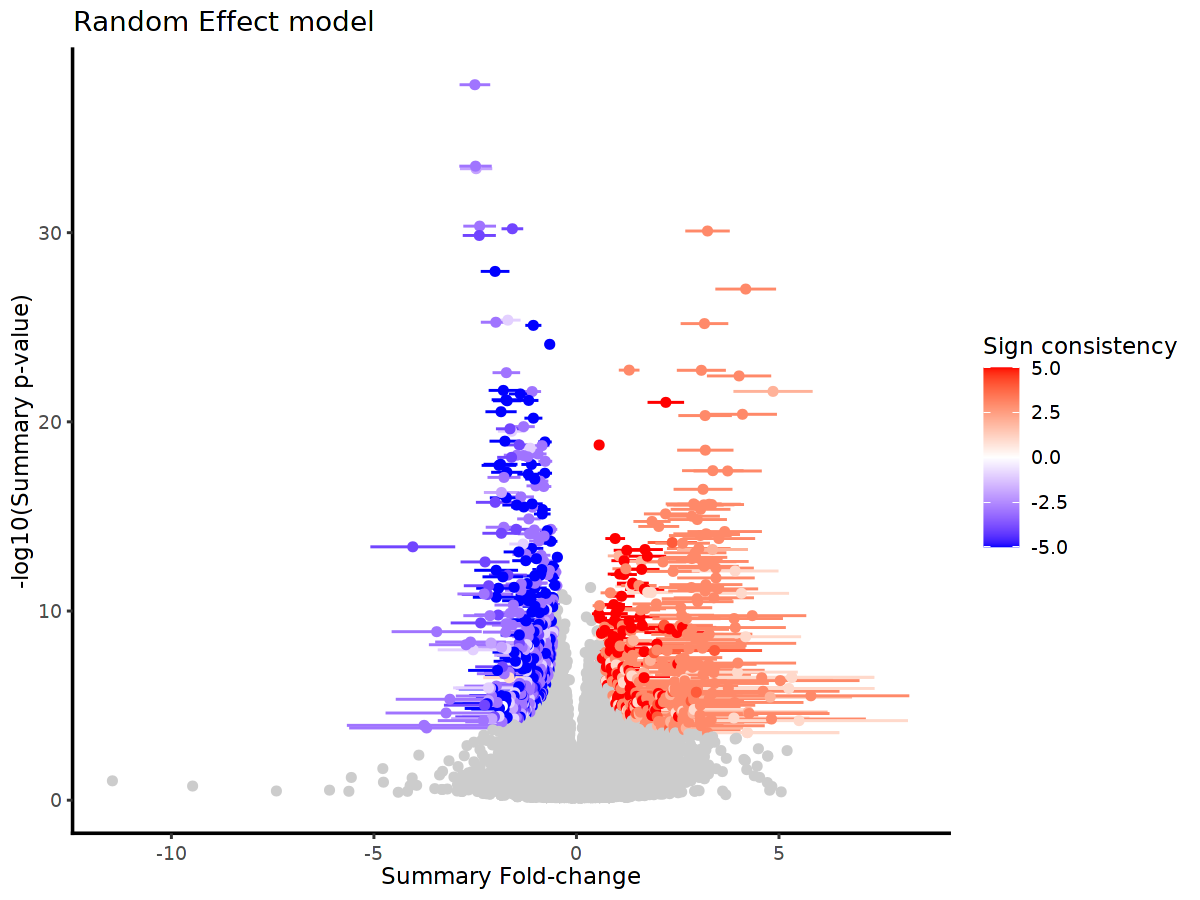

In [19]:
options(repr.plot.width = 8,
        repr.plot.height = 6,
        repr.plot.pointsize = 12,
        repr.plot.family = 'mono',
        repr.plot.res = 150)
metavolcano_plot

## Results Table for the Random Effect Model

In [20]:
head(rem_result)

,Symbol,signcon,randomSummary,randomCi.lb,randomCi.ub,randomP,het_QE,het_QEp,het_QM,het_QMp,error,rank
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
1,LGALS7B,2,4.853265,3.874728,5.831801,2.456744e-22,6.365113,0.09513661,94.49531,2.456744e-22,FALSE,1
2,IGHG1,3,4.178678,3.428455,4.928900,9.576831e-28,2.421309,0.29800210,119.17743,9.576831e-28,FALSE,2
3,IGHV3-19,3,4.014622,3.220674,4.808570,3.743467e-23,1.541916,0.46256968,98.22023,3.743467e-23,FALSE,3
4,IGHV1-3,3,4.098543,3.246956,4.950131,3.986546e-21,1.374374,0.50298895,88.98084,3.986546e-21,FALSE,4
5,MS4A6E,3,3.235996,2.686451,3.785541,8.173619e-31,2.309133,0.31519419,133.20027,8.173619e-31,FALSE,5
6,IGHV3-49,3,3.160398,2.572046,3.748749,6.406564e-26,1.638832,0.44068900,110.84243,6.406564e-26,FALSE,6


## Forest Plot 

> Any gene used in the meta analysis can be plotted using the `plot_forest()` function

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


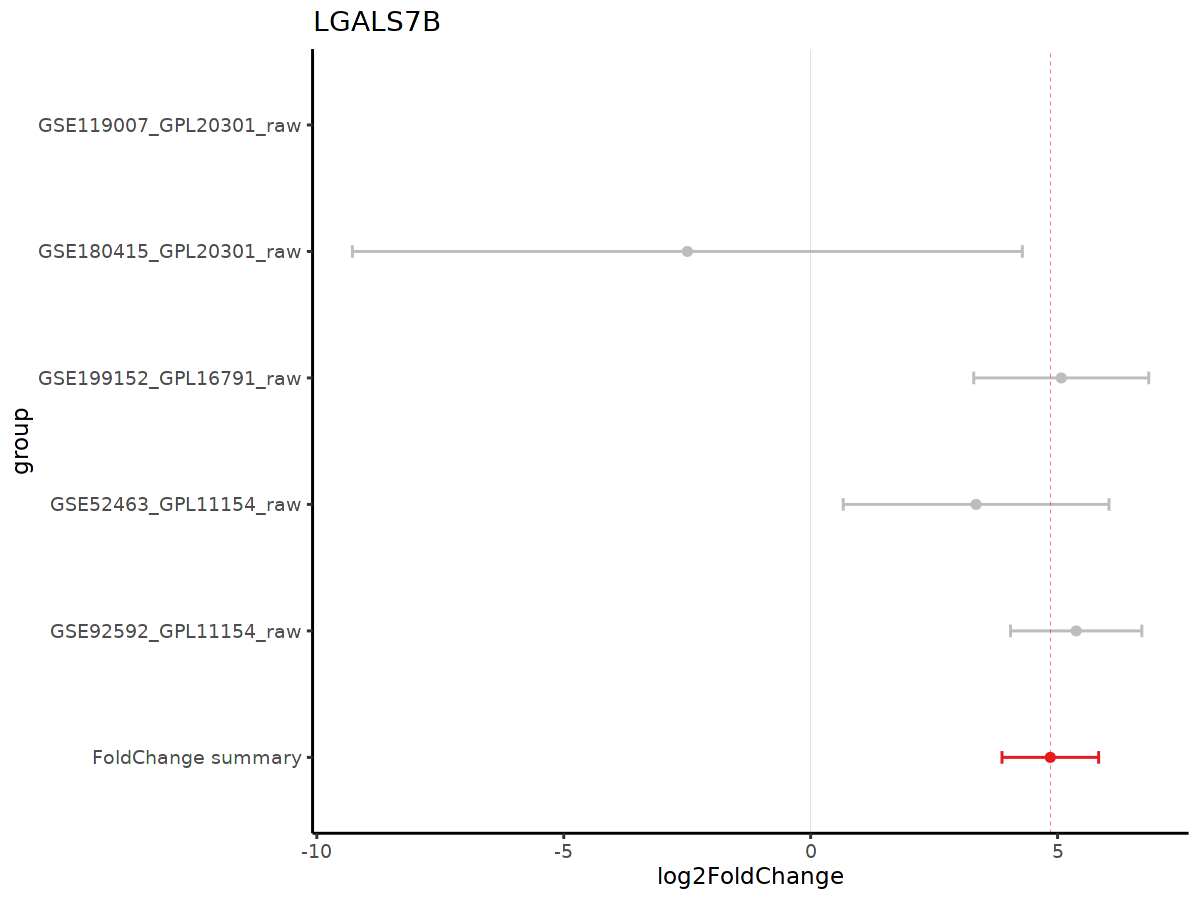

In [21]:
gene_name <- 'LGALS7B' # gene name for which forest plots need to be done
plot_forest(gene=gene_name, rem_model=meta_degs_rem)

---

## KEGG Gene Set enrichment

---
### Parameters:

`random_effect_res`: path to the results of random effect model

`logfc_cutoff`: cutoff value for logFC for filtering the REM results.

`pval_cutoff`: cutoff value for P-value for filtering the REM result

`organism`: either `human` or `mouse` for GSEA analysis

In [22]:
random_effect_res = 'results/rem_model_res.csv'
logfc_cutoff = 1.5
pval_cutoff = 0.05
organism = 'human'
gene_set_map = {
    'human': 'KEGG_2021_Human',
    'mouse': 'KEGG_2019_Mouse'
}
assert organism == 'human' or organism == 'mouse', "Invalid organism should be either 'human' or 'mouse'"

In [23]:
def filter_genes(df, logfc_cutoff, pval_cutoff):
    filtered_df = df.query(f'abs(randomSummary) >= {logfc_cutoff}') \
        .query(f'randomP <= {pval_cutoff}') \
        .dropna().copy()
    return filtered_df


def get_geene_rank(df):
    rank_df = df.copy()
    rank_df['rank'] = -np.log10(df.randomP) * df.randomSummary 
    rank_df = rank_df.sort_values('rank')
    return rank_df[['Symbol', 'rank']]


def plot_kegg_dotplot(enr, title=gene_set_map[organism]):
    
    output_png = f'results/{title}_dotplot'
    
    gp.dotplot(enr.res2d,
                title=title,
                figsize=(3, 5),
                cmap='viridis_r',
                ofname=output_png)
    
    ax = gp.dotplot(enr.res2d, title=title, cmap='viridis_r', size=10, figsize=(3,5))
    return ax

def plot_kegg_barplot(enr, title=gene_set_map[organism]):
    
    output_png = f'results/{title}_barplot'
    
    gp.barplot(enr.res2d,
                title=title,
                figsize=(4, 5),
                color='darkred',
                ofname=output_png)
    ax = gp.barplot(enr.res2d, title=title, figsize=(4, 5), color='darkred')
    return ax

# loading the Random Effect Model Results
rem_res = pd.read_csv(random_effect_res, index_col=0)
filtered_rem_res = filter_genes(rem_res, logfc_cutoff, pval_cutoff)
gene_ranking_df = get_geene_rank(filtered_rem_res)

enr = gp.enrichr(gene_list=gene_ranking_df['Symbol'],
                 gene_sets=gene_set_map[organism],
                 organism=organism,
                 outdir=None
                )
enr.res2d.to_csv(f'results/{gene_set_map[organism]}.csv')

In [24]:
enr.res2d.head(3)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Ascorbate and aldarate metabolism,7/30,0.000107,0.015855,0,0,7.745753,70.806497,UGT1A10;UGT1A5;UGT1A4;UGT1A3;UGT2A2;UGT2A1;UGT1A6
1,KEGG_2021_Human,Bile secretion,12/90,0.000154,0.015855,0,0,3.930256,34.503766,UGT1A10;CA2;SLCO1B3;SLCO1A2;UGT1A5;NR1H4;UGT1A...
2,KEGG_2021_Human,Pentose and glucuronate interconversions,7/34,0.000248,0.017027,0,0,6.596860,54.768436,UGT1A10;UGT1A5;UGT1A4;UGT1A3;UGT2A2;UGT2A1;UGT1A6


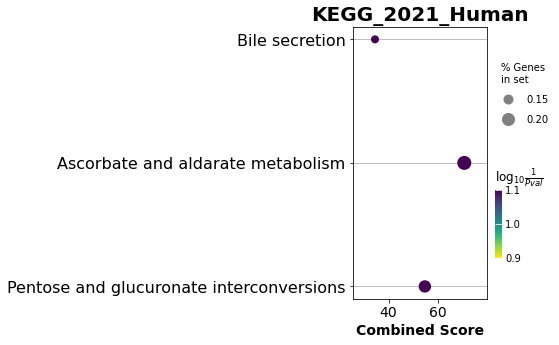

In [25]:
plot_kegg_dotplot(enr);

Failed to execute statement __vars__={  }
pickle.dumps(__vars__): list index out of range


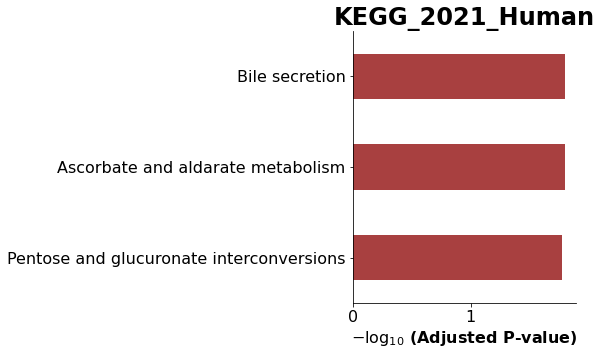

In [26]:
plot_kegg_barplot(enr);

## Future Scope:

- Benchmarking for how many datasets are needed for meta-analysis
- QC Report and results segregation
- Comparison of meta analysis using microarray or RNAseq or both together for a given disease 
- Additionally, the solution will generate a set of customizable templates for presenting the results in a clear and concise manner.
- Other omics - proteomics & metabolomics
